<a href="https://colab.research.google.com/github/chavgova/My-AI/blob/master/emotion_recognition_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT

In [ ]:
#this is the copy of another projecct and ill make changes to see how i can make it better 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from matplotlib.axis import Axis
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
import os

In [ ]:
from google.colab import drive
import os

path = '/content/drive/My Drive/My_AI/RawData'

mylist = []
mylist = os.listdir(path)

#print(mylist)	



In [ ]:
print(len(mylist))

4642


LABLES

In [ ]:
import re

feeling_list=[]
dataset = ''

for item in mylist:
    file_label = item[6:-16]
    try:
      file_label = int(file_label)
      dataset = 'RAVDESS'
    except:
      if (item[:1] == 'Y') or (item[:1] == 'O'):
        file_label = re.split('_|\.', item)[2]
        dataset = 'TESS'
      else: dataset = 'SAVEE'

    if dataset == 'RAVDESS':
      if int(item[18:-4])%2==0:  #female
          if file_label == 1:
            feeling_list.append('female_neutral')
          elif file_label == 2:
            feeling_list.append('female_calm')
          elif file_label == 3:
            feeling_list.append('female_happy')
          elif file_label == 4:
            feeling_list.append('female_sad')
          elif file_label == 5:
            feeling_list.append('female_angry')
          elif file_label == 6:
            feeling_list.append('female_fearful')
          elif file_label == 7:
            feeling_list.append('female_disgust')
          elif file_label == 8:
            feeling_list.append('female_surprised')
      else:
          if file_label== 1:
            feeling_list.append('male_neutral')
          elif file_label == 2:
            feeling_list.append('male_calm')
          elif file_label == 3:
            feeling_list.append('male_happy')
          elif file_label == 4:
            feeling_list.append('male_sad')
          elif file_label == 5:
            feeling_list.append('male_angry')
          elif file_label == 6:
            feeling_list.append('male_fearful')
          elif file_label == 7:
            feeling_list.append('male_disgust')
          elif file_label == 8:
            feeling_list.append('male_surprised')

    elif dataset == 'TESS':
      if file_label == 'neutral': feeling_list.append('female_neutral')
      elif file_label == 'angry': feeling_list.append('female_angry')
      elif file_label == 'disgust': feeling_list.append('female_disgust')
      elif file_label == 'ps': feeling_list.append('female_surprised')
      elif file_label == 'happy': feeling_list.append('female_happy')
      elif file_label == 'sad': feeling_list.append('female_sad')
      elif file_label == 'fear': feeling_list.append('female_fearful')

    elif dataset == 'SAVEE':
      if item[:1]=='a':
        feeling_list.append('male_angry')
      elif item[:1]=='f':
        feeling_list.append('male_fearful')
      elif item[:1]=='h':
        feeling_list.append('male_happy')
      elif item[:1]=='n':
        feeling_list.append('male_neutral')
      elif item[:2]=='sa':
        feeling_list.append('male_sad')
      elif item[:2]=='su':
        feeling_list.append('male_surprised')
      elif item[:1]=='d':
        feeling_list.append('male_disgust')


In [ ]:
import pandas as pd

labels = pd.DataFrame(feeling_list)
labels #[1600:1660]      #print

,0
0,female_fearful
1,female_surprised
2,female_disgust
3,female_fearful
4,female_angry
...,...
4637,male_sad
4638,male_neutral
4639,male_neutral
4640,male_happy


Getting the features of audio files using librosa

In [ ]:
import librosa
import numpy as np

def extract_feature(my_file, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X, sample_rate = librosa.core.load(my_file)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))  # 40 values 
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))  # 12 values 
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))  # 128 values 
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast)) # 7 values 
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz)) # 6 values 

    return result

#f = os.fspath('/content/drive/My Drive/My_AI/RawData/03-01-08-01-01-02-01.wav')
#a = extract_feature(f, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)
#print(a, a.shape)

In [46]:
data_frame = pd.DataFrame(columns=['all_features'])
bookmark=0

#mylist = mylist[:100]
for index,y in enumerate(mylist):
      all_features_ndarray = extract_feature('/content/drive/My Drive/My_AI/RawData/'+ y, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)
      data_frame.loc[bookmark] = [all_features_ndarray]
      bookmark=bookmark+1
        
#df[:5]    #print 


In [47]:
data_frame

,all_features
0,"[-316.3982820454405, 39.7822605437439, -19.189..."
1,"[-342.88055472969165, 45.95027168893386, -12.3..."
2,"[-419.17375831355355, 79.36795418715639, 4.317..."
3,"[-293.87641633233585, 22.448290415751732, -9.3..."
4,"[-367.20304493461066, 40.17211376308315, -2.72..."
...,...
4637,"[-386.0892486848382, 110.02557215362587, 21.23..."
4638,"[-442.40133523714957, 112.92528455032522, 34.9..."
4639,"[-422.7050269459787, 120.85873358076398, 28.69..."
4640,"[-302.1125750691463, 111.5075339801829, 5.2672..."


In [48]:
data_frame = pd.DataFrame(data_frame['all_features'].values.tolist())
data_frame[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192
0,-316.398282,39.782261,-19.189288,10.220406,-3.955771,-5.367594,-8.272648,-5.151310,-8.576905,6.269787,-18.821991,4.428211,-0.106290,1.069031,0.127908,-5.440494,-1.287617,8.693481,-3.554609,15.700572,10.750350,7.285267,2.611756,5.705450,-1.574549,7.675168,0.213019,1.292888,-0.059914,-0.239021,-3.433251,3.604023,-4.753794,3.056424,-1.128346,1.007652,-1.190492,1.005525,1.607905,3.564362,...,0.001503,0.001342,0.002295,0.002372,0.002861,0.006071,0.006472,0.008890,0.007342,0.005558,0.005838,0.005698,0.005810,0.005224,0.004468,0.006076,0.005546,0.006286,0.006116,0.011182,0.018300,0.012381,0.005446,0.009796,0.008335,0.003382,0.000305,13.868668,20.999650,21.803635,19.194679,20.722318,21.901160,32.323680,-0.003346,-0.014993,0.020096,-0.003074,-0.000737,0.012189
1,-342.880555,45.950272,-12.301437,9.037878,-17.194069,-13.218251,-8.020786,-17.228617,-14.822261,-2.137459,-10.392415,9.892669,-10.905327,10.679729,-1.748336,3.126162,8.133520,1.703298,-3.835112,2.226029,-3.639254,5.678473,-1.003672,2.825912,-0.287353,2.221059,3.942444,7.379460,3.065108,9.795497,3.641103,7.876033,6.162153,7.126329,2.823838,5.375054,-0.816559,5.629844,2.231022,2.599346,...,0.002129,0.001635,0.001341,0.000785,0.000476,0.000568,0.001456,0.001768,0.002265,0.002550,0.003186,0.004343,0.002630,0.002409,0.004420,0.007988,0.007283,0.005904,0.006900,0.006846,0.008745,0.006972,0.003461,0.003092,0.003775,0.002511,0.000264,17.622480,18.869340,22.381613,19.010813,20.511432,21.295596,31.370796,-0.006591,-0.008237,-0.013012,-0.001128,-0.000918,-0.002161
2,-419.173758,79.367954,4.317339,35.424460,-7.966875,-4.674928,-0.599713,-17.962315,-12.630474,-7.361007,-12.680626,0.716001,-8.898681,3.046107,-6.071597,-4.969251,5.618301,-5.994555,-6.884007,1.297542,-8.073998,1.653511,-2.665310,2.601730,-2.046081,0.588888,-2.019464,3.216928,4.282435,8.064075,-0.794268,5.343579,-0.834786,0.198284,0.655829,3.781555,5.973052,7.372418,6.851194,7.075016,...,0.000393,0.000156,0.000118,0.000213,0.000269,0.000675,0.000828,0.000593,0.000774,0.000674,0.000787,0.001000,0.001052,0.000936,0.001152,0.001685,0.002630,0.003414,0.003983,0.005403,0.007188,0.004412,0.001615,0.002020,0.003231,0.001068,0.000168,18.847273,20.424341,21.850558,17.300010,21.275250,21.865844,29.752038,-0.010095,-0.000362,-0.047308,-0.015524,-0.001998,-0.003304
3,-293.876416,22.448290,-9.335532,26.431156,-4.734249,2.973992,-2.389638,-10.468726,-2.792421,0.925244,-13.743108,8.317492,-8.206837,2.610541,0.372752,-2.467361,-0.495091,12.504432,2.665887,13.333836,6.096934,2.939573,-2.406452,4.838465,1.819071,9.418154,-0.115926,0.947575,-1.769516,3.020390,-4.262996,2.740926,-5.912998,-0.717437,-0.780768,3.394294,0.121856,5.221049,0.308147,2.509442,...,0.133340,0.131750,0.114145,0.108087,0.085247,0.071662,0.049761,0.042576,0.034288,0.023788,0.024551,0.025097,0.024018,0.028981,0.030698,0.035535,0.035312,0.031429,0.029649,0.039931,0.044069,0.031701,0.013745,0.018371,0.012888,0.005912,0.000552,13.557616,20.720947,21.244924,19.248067,21.323559,20.853838,31.759059,0.000611,-0.000084,-0.013852,-0.064953,0.006751,0.000230
4,-367.203045,40.172114,-2.722191,17.633493,-15.947783,-5.629244,0.581348,-18.207309,-2.655200,-3.220760,-18.233323,12.147264,-11.930273,5.846366,-1.782772,-4.524518,2.751071,0.070683,-5.328440,5.018463,-5.571851,-2.214062,-7.623350,-2.618450,-2.444535,-0.937296,-2.697148,4.923608,7.678478,14.626429,11.462202,15.358377,9.920862,7.825822,2.132594,4.316476,2.754338,7.616782,2.611640,0.899905,...,0.000616,0.000405,0.000610,0.000777,0.000929,0.002041,0.001509,0.001979,0.001734,0.002036,0.002950,0.004354,0.002887,0.003199,0.004200,0.007140,0.007721,0.006963,0.009832,0.018136,0.027777,0.011011,0.006270,0.011737,0.012987,0.008119,0.000792,18.718335,21.817464,23.389298

In [49]:
data_frame_labels = pd.concat([data_frame,labels], axis=1)
data_frame_labels = data_frame_labels.rename(index=str, columns={"0": "label"})
data_frame_labels    #print

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
0,-316.398282,39.782261,-19.189288,10.220406,-3.955771,-5.367594,-8.272648,-5.151310,-8.576905,6.269787,-18.821991,4.428211,-0.106290,1.069031,0.127908,-5.440494,-1.287617,8.693481,-3.554609,15.700572,10.750350,7.285267,2.611756,5.705450,-1.574549,7.675168,0.213019,1.292888,-0.059914,-0.239021,-3.433251,3.604023,-4.753794,3.056424,-1.128346,1.007652,-1.190492,1.005525,1.607905,3.564362,...,0.001342,0.002295,0.002372,0.002861,0.006071,0.006472,0.008890,0.007342,0.005558,0.005838,0.005698,0.005810,0.005224,4.467806e-03,6.076175e-03,5.545964e-03,6.285772e-03,6.115529e-03,1.118162e-02,1.830000e-02,1.238102e-02,5.446300e-03,9.795647e-03,8.335074e-03,3.382275e-03,3.049260e-04,13.868668,20.999650,21.803635,19.194679,20.722318,21.901160,32.323680,-0.003346,-0.014993,0.020096,-0.003074,-0.000737,0.012189,female_fearful
1,-342.880555,45.950272,-12.301437,9.037878,-17.194069,-13.218251,-8.020786,-17.228617,-14.822261,-2.137459,-10.392415,9.892669,-10.905327,10.679729,-1.748336,3.126162,8.133520,1.703298,-3.835112,2.226029,-3.639254,5.678473,-1.003672,2.825912,-0.287353,2.221059,3.942444,7.379460,3.065108,9.795497,3.641103,7.876033,6.162153,7.126329,2.823838,5.375054,-0.816559,5.629844,2.231022,2.599346,...,0.001635,0.001341,0.000785,0.000476,0.000568,0.001456,0.001768,0.002265,0.002550,0.003186,0.004343,0.002630,0.002409,4.419637e-03,7.988392e-03,7.282747e-03,5.903650e-03,6.899837e-03,6.846244e-03,8.745193e-03,6.971703e-03,3.461123e-03,3.091562e-03,3.774827e-03,2.511465e-03,2.638007e-04,17.622480,18.869340,22.381613,19.010813,20.511432,21.295596,31.370796,-0.006591,-0.008237,-0.013012,-0.001128,-0.000918,-0.002161,female_surprised
2,-419.173758,79.367954,4.317339,35.424460,-7.966875,-4.674928,-0.599713,-17.962315,-12.630474,-7.361007,-12.680626,0.716001,-8.898681,3.046107,-6.071597,-4.969251,5.618301,-5.994555,-6.884007,1.297542,-8.073998,1.653511,-2.665310,2.601730,-2.046081,0.588888,-2.019464,3.216928,4.282435,8.064075,-0.794268,5.343579,-0.834786,0.198284,0.655829,3.781555,5.973052,7.372418,6.851194,7.075016,...,0.000156,0.000118,0.000213,0.000269,0.000675,0.000828,0.000593,0.000774,0.000674,0.000787,0.001000,0.001052,0.000936,1.152094e-03,1.684913e-03,2.629799e-03,3.414122e-03,3.983024e-03,5.403495e-03,7.188147e-03,4.411572e-03,1.614888e-03,2.019921e-03,3.231404e-03,1.068011e-03,1.677236e-04,18.847273,20.424341,21.850558,17.300010,21.275250,21.865844,29.752038,-0.010095,-0.000362,-0.047308,-0.015524,-0.001998,-0.003304,female_disgust
3,-293.876416,22.448290,-9.335532,26.431156,-4.734249,2.973992,-2.389638,-10.468726,-2.792421,0.925244,-13.743108,8.317492,-8.206837,2.610541,0.372752,-2.467361,-0.495091,12.504432,2.665887,13.333836,6.096934,2.939573,-2.406452,4.838465,1.819071,9.418154,-0.115926,0.947575,-1.769516,3.020390,-4.262996,2.740926,-5.912998,-0.717437,-0.780768,3.394294,0.121856,5.221049,0.308147,2.509442,...,0.131750,0.114145,0.108087,0.085247,0.071662,0.049761,0.042576,0.034288,0.023788,0.024551,0.025097,0.024018,0.028981,3.069844e-02,3.553510e-02,3.531232e-02,3.142908e-02,2.964862e-02,3.993142e-02,4.406870e-02,3.170089e-02,1.374528e-02,1.837071e-02,1.288842e-02,5.912021e-03,5.524261e-04,13.557616,20.720947,21.244924,19.248067,21.323559,20.853838,31.759059,0.000611,-0.000084,-0.013852,-0.064953,0.006751,0.000230,female_fearful
4,-367.203045,40.172114,-2.722191,17.633493,-15.947783,-5.629244,0.581348,-18.207309,-2.655200,-3.220760,-18.233323,12.147264,-11.930273,5.846366,-1.782772,-4.524518,2.751071,0.070683,-5.328440,5.018463,-5.571851,-2.214062,-7.623350,-2.618450,-2.444535,-0.937296,-2.697148,4.923608,7.678478,14.626429,11.462202,15.358377,9.920862,7.825822,2.132594,4.316476,2.754338,7.616782,2.611640,0.899905,...,0.000405,0.000610,0.000777,0.000929,0.00

In [50]:
from sklearn.utils import shuffle
data_frame_labels = shuffle(data_frame_labels)
data_frame_labels
    #print 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
4297,-386.650391,112.257884,32.538729,55.920757,-11.472445,-6.594399,1.843466,3.526906,-9.719948,0.272446,-1.445023,-3.198936,-0.375138,-0.255478,6.328461,0.563520,-0.351230,1.548781,0.207166,-4.937928,1.837546,4.244088,-1.562167,-2.103844,0.455603,-2.398293,0.779373,4.251547,-1.899298,-1.610627,2.444678,3.864808,2.629697,0.894058,2.185032,1.397219,0.770842,2.446485,2.546150,1.161653,...,0.003463,0.003928,0.004474,0.004706,0.003627,0.002137,0.001433,0.001461,0.001296,0.001115,0.000800,0.000628,0.000380,0.000146,0.000079,0.000037,0.000022,0.000007,1.178434e-06,2.218054e-07,1.456940e-07,1.695652e-07,2.150158e-07,3.132837e-07,4.433140e-07,4.937361e-07,31.907075,14.005291,17.960368,19.927870,19.911672,21.453665,41.467029,0.004777,0.006754,-0.010323,0.021967,-0.006128,0.000325,male_neutral
834,-299.239255,30.882220,-7.624576,10.072476,2.918595,7.535072,7.858384,-3.801196,-3.628800,7.648708,-16.975320,9.263544,-2.766942,5.553412,1.373609,-5.312648,2.379411,10.954330,-7.677073,9.850016,1.903584,0.239441,-1.386426,1.123141,-4.174776,5.694065,-1.530366,1.730373,-0.904936,2.925451,-0.481910,8.660168,-1.469448,1.411537,-3.667900,3.204587,-1.019160,1.440307,-0.777350,1.583379,...,0.002249,0.002680,0.004001,0.004094,0.005872,0.004991,0.006134,0.005321,0.005888,0.003499,0.003331,0.003257,0.004754,0.005569,0.008002,0.009688,0.009170,0.008838,1.496371e-02,1.553523e-02,1.079949e-02,1.221468e-02,9.453340e-03,7.553417e-03,4.292128e-03,5.638074e-04,14.940984,20.068666,22.954760,18.938000,19.845712,22.225938,32.173067,-0.003287,0.011098,-0.023515,0.002380,0.002589,0.006072,female_fearful
3244,-631.708227,57.812441,-4.768079,16.799045,8.447084,-2.606081,-2.490354,-16.618601,-6.383768,3.015490,-4.969042,-2.969460,0.419781,1.585797,0.444348,-0.217427,-2.728774,6.449055,3.834710,7.104997,5.449810,6.690715,4.682529,10.976344,6.711400,7.975050,3.219573,7.475042,5.194706,4.736429,2.526778,2.135177,0.510637,2.935238,1.255736,2.274014,0.220092,1.068158,-1.494288,-0.523183,...,0.000014,0.000010,0.000007,0.000010,0.000008,0.000007,0.000008,0.000010,0.000011,0.000012,0.000011,0.000009,0.000007,0.000005,0.000005,0.000006,0.000005,0.000003,7.796216e-06,1.226196e-05,1.306513e-05,1.055138e-05,6.419980e-06,5.745188e-06,2.226130e-06,1.491235e-07,19.643638,17.510712,17.153081,16.500626,17.249775,18.054792,29.422410,-0.033702,0.019052,0.042628,-0.013429,0.021452,0.024160,female_sad
2640,-374.523802,68.953669,-6.685906,-11.386214,-19.893413,-8.508675,-19.998765,5.392508,-20.501850,-2.425175,-7.795433,4.309095,-4.337402,7.363466,-1.212704,-1.221640,3.182487,-7.681467,-3.607773,-14.531074,-8.442779,4.721248,1.504575,25.715152,31.718579,30.731710,23.506435,13.048573,-5.005679,2.128138,5.324190,7.924119,4.545379,-5.735838,1.562780,4.584207,1.656216,5.483671,-4.200719,-1.019264,...,0.001048,0.001063,0.000943,0.000927,0.000844,0.001453,0.002571,0.001788,0.003070,0.004082,0.003551,0.003179,0.002320,0.001538,0.001574,0.001422,0.001464,0.000897,5.048423e-04,3.514573e-04,2.229529e-04,1.441629e-04,1.475965e-04,1.462321e-04,5.302817e-05,2.691927e-06,27.402455,26.814298,28.764361,26.920250,26.024028,22.117023,34.723547,-0.009678,0.002519,-0.096969,-0.020635,0.007121,-0.010030,female_angry
4456,-387.594077,98.339948,11.329239,38.251268,19.280561,3.486709,-20.510567,-0.764894,-1.724635,-10.851204,3.536598,1.194512,-1.376731,-0.048999,7.186931,-2.778921,-2.712673,6.793405,-1.030662,-1.296969,-0.225800,-0.507843,1.198158,-1.930688,-0.527245,-2.198799,-1.828542,1.749463,-1.271855,0.246354,2.280063,2.205477,4.471838,8.225115,13.212310,15.069090,12.131318,7.867216,4.898035,4.327289,...,0.004526,0.004354,0.003556,0.002637,0.002151,0.000833,0.000293,0.000210,0.000112,0.000106,0.000065,0.000043,0.000024,0.000012,0.000008,0

SAVE DATASET FEATURES AND LABELS 

In [51]:
import pickle

with open('/content/drive/My Drive/My_AI/datasets_RAVDESS-TESS-SAVEE_features&labels.pkl', 'wb') as f:
  pickle.dump(data_frame_labels, f)


LOAD DATASET FEATURES AND LABELS 

In [52]:
import pickle

with open('/content/drive/My Drive/My_AI/datasets_RAVDESS-TESS-SAVEE_features&labels.pkl', 'rb') as f:
  data_frame_labels = pickle.load(f)


Dividing the data into test and train

In [53]:
data_frame_labels_set = np.random.rand(len(data_frame_labels)) < 0.8
train = data_frame_labels[data_frame_labels_set]
test = data_frame_labels[~data_frame_labels_set]

In [54]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
1240,-307.732879,25.592316,-3.501367,14.304056,4.725114,-5.298615,3.568359,-4.668853,-4.798215,5.631594,-19.533544,8.006050,-5.068841,4.140480,-2.766861,-7.030049,-3.986964,1.285691,-8.821697,13.894542,6.861052,9.645828,3.526570,1.497147,-1.048877,7.893556,0.207116,2.384008,-3.837413,-1.825039,-4.411063,5.408285,-3.907726,-3.021152,-6.454944,2.896349,-1.986164,0.045916,0.664689,8.254089,...,0.000654,0.000848,0.001234,0.001770,0.002190,0.003411,0.003375,0.002465,0.003801,0.005201,0.005560,0.004089,0.004814,0.006038,0.013030,0.015767,0.008670,0.007942,0.015074,0.033593,0.023195,0.009712,0.010881,0.008679,3.097362e-03,2.911349e-04,13.219047,20.352286,22.785145,19.801779,19.682121,22.255386,32.409962,0.003503,0.007819,-0.050253,0.008973,-0.008657,-0.006939,female_fearful
3165,-511.007085,31.945698,-24.223425,-4.789984,-16.094898,-10.941045,-15.406099,-14.200820,-6.566537,-2.529292,-8.562836,-1.135491,-7.540392,-4.110976,-4.231794,-7.035539,-7.718561,-5.717851,-6.352912,-0.497729,0.733520,1.473568,1.797738,2.168342,-0.664502,1.411178,0.298783,4.062870,3.476150,3.815049,2.275186,1.994115,-1.297801,1.165450,0.442952,1.852469,-0.971368,-2.209750,-2.687575,0.736702,...,0.000581,0.001089,0.001382,0.001448,0.001626,0.002299,0.002136,0.002880,0.003737,0.004116,0.004126,0.003216,0.003171,0.004360,0.004850,0.005238,0.003744,0.003348,0.003332,0.002638,0.002458,0.001466,0.001180,0.001216,6.006975e-04,4.521536e-05,16.029565,17.406193,18.861111,17.093563,17.917425,17.951945,29.171105,-0.010393,0.000064,0.005394,0.015457,-0.000893,0.009994,female_disgust
3692,-631.581113,63.322167,-6.133518,15.783362,6.213468,-1.268490,-6.906775,-4.491343,-13.980429,-1.056522,-0.162011,-6.067974,3.119391,-3.652400,-2.460494,3.520350,-8.102169,-2.503962,0.046346,-1.456886,-6.443019,0.177802,-3.876437,-5.323302,-0.727576,-0.846276,-3.754684,-0.384882,-3.925401,-1.015699,-1.764585,-3.306966,-1.825903,-2.840103,-3.215978,-1.504805,-1.233874,-1.958339,-2.428435,-0.957737,...,0.000033,0.000093,0.000132,0.000076,0.000067,0.000040,0.000033,0.000039,0.000018,0.000010,0.000016,0.000019,0.000014,0.000012,0.000007,0.000003,0.000006,0.000013,0.000009,0.000006,0.000004,0.000003,0.000003,0.000002,1.665706e-06,1.635397e-07,20.461025,12.958922,16.120549,14.954918,15.868108,18.276043,28.922197,-0.023029,0.017989,0.016078,-0.014450,0.011257,0.013391,male_happy
3131,-722.989996,52.470446,2.220584,8.748189,-4.296806,-2.782603,-10.114308,-8.095959,-7.046374,-2.590331,-9.491808,-1.496374,-5.960143,-0.200968,-2.661576,-4.068764,-1.601161,-4.083841,-3.628881,-3.124673,-4.035014,-3.068606,-4.043696,-1.241058,-3.175357,-1.067651,-2.137118,0.030353,-1.943339,3.081683,3.636534,8.377307,9.156476,10.506617,7.574639,4.032608,1.503296,-0.013415,-0.148384,1.326447,...,0.000029,0.000038,0.000015,0.000032,0.000058,0.000048,0.000054,0.000031,0.000018,0.000012,0.000010,0.000010,0.000007,0.000009,0.000008,0.000006,0.000006,0.000005,0.000005,0.000007,0.000005,0.000004,0.000003,0.000002,6.142002e-07,8.204564e-08,15.127345,16.109514,18.020295,15.625442,16.564967,16.716649,27.359196,-0.008512,0.010013,0.027087,0.049638,0.001229,-0.004243,female_sad
1966,-500.331811,74.872379,13.990074,9.951755,6.174220,13.654649,-4.313725,-12.971571,-16.964931,-3.914993,-9.519672,1.128111,-8.451013,4.708410,10.178107,3.341173,-1.637440,9.545769,-6.770233,0.190911,2.588923,0.747971,-3.945993,0.038954,-12.155491,0.661364,-4.710800,-0.035697,-4.909690,-0.143288,-9.226500,-3.154366,-0.231455,16.099224,28.119546,35.227814,37.682198,28.266703,10.711125,4.299321,...,0.000170,0.000120,0.000093,0.000114,0.000096,0.000160,0.000135,0.000134,0.000141,0.000115,0.000272,0.000369,0.000187,0.000128,0.000100,0.000116,0.000063,0.000083,0.000059,0.000052,0.000041,0.000049

In [55]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]

In [56]:
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

In [57]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [58]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [59]:
X_train.shape

(3705, 193)

Changing dimension for CNN model

In [60]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)
print(x_testcnn)

[[[-2.99239255e+02]
  [ 3.08822198e+01]
  [-7.62457640e+00]
  ...
  [ 2.37970484e-03]
  [ 2.58851992e-03]
  [ 6.07209865e-03]]

 [[-6.31708227e+02]
  [ 5.78124405e+01]
  [-4.76807885e+00]
  ...
  [-1.34287940e-02]
  [ 2.14516283e-02]
  [ 2.41602477e-02]]

 [[-4.05668159e+02]
  [ 7.65023514e+01]
  [ 1.40133347e+01]
  ...
  [-4.31035448e-02]
  [ 4.69869340e-03]
  [ 4.11917974e-03]]

 ...

 [[-5.94363815e+02]
  [ 7.78807896e+01]
  [-7.15820770e+00]
  ...
  [-3.84037088e-02]
  [ 7.89535568e-03]
  [ 5.87416227e-04]]

 [[-3.08411276e+02]
  [ 2.47593492e+01]
  [-8.78725058e+00]
  ...
  [-1.31865347e-03]
  [-4.99313295e-03]
  [-6.50588496e-03]]

 [[-4.01165881e+02]
  [ 4.12048703e+01]
  [ 1.16705182e-01]
  ...
  [ 1.53999896e-01]
  [-2.23352031e-02]
  [ 1.05504559e-02]]]


In [61]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(193,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Dropout(0.1))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(16))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 193, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 193, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 193, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 193, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 193, 128)          82048     
_________________________________________________________________
activation_2 (Activation)    (None, 193, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 128)           0

In [63]:
model.compile(loss= 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

Removed the whole training part for avoiding unnecessary long epochs list

In [64]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=150, validation_data=(x_testcnn, y_test))

Epoch 1/150
116/116 [==============================] - 34s 296ms/step - loss: 2.1068 - accuracy: 0.3509 - val_loss: 1.4332 - val_accuracy: 0.5955
Epoch 2/150
116/116 [==============================] - 35s 303ms/step - loss: 1.3994 - accuracy: 0.5960 - val_loss: 1.1668 - val_accuracy: 0.6158
Epoch 3/150
116/116 [==============================] - 34s 294ms/step - loss: 1.1605 - accuracy: 0.6583 - val_loss: 1.0326 - val_accuracy: 0.6841
Epoch 4/150
116/116 [==============================] - 35s 298ms/step - loss: 1.0239 - accuracy: 0.6812 - val_loss: 0.9465 - val_accuracy: 0.7118
Epoch 5/150
116/116 [==============================] - 36s 308ms/step - loss: 0.9397 - accuracy: 0.7034 - val_loss: 0.8844 - val_accuracy: 0.7268
Epoch 6/150
116/116 [==============================] - 34s 296ms/step - loss: 0.8755 - accuracy: 0.7155 - val_loss: 0.8382 - val_accuracy: 0.7407
Epoch 7/150
116/116 [==============================] - 34s 296ms/step - loss: 0.8257 - accuracy: 0.7309 - val_loss: 0.8501 -

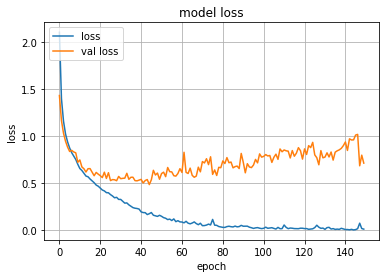

In [65]:
plt.figure()
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['loss', 'val loss'], loc='upper left')
plt.show()

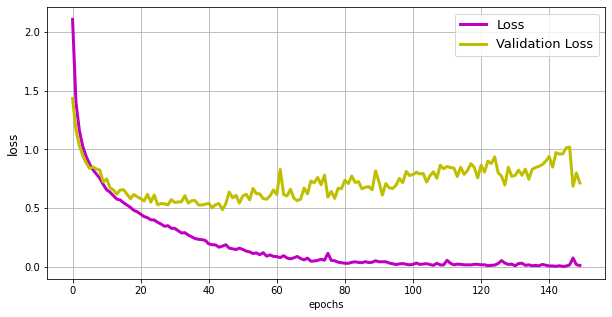

In [66]:
plt.figure(figsize=(10,5))

plt.plot(cnnhistory.history['loss'], 'm', linewidth=3)
plt.plot(cnnhistory.history['val_loss'], 'y', linewidth=3)
plt.legend(['Loss', 'Validation Loss'], fontsize=13)
plt.xlabel('epochs')
plt.ylabel('loss', fontsize=12)
plt.grid(True)
plt.show()

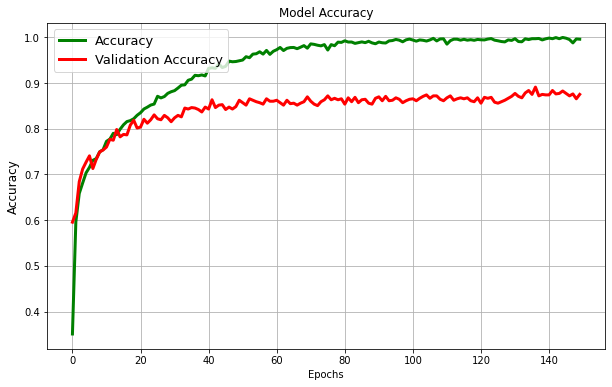

In [67]:
plt.figure(figsize=(10,6), frameon=True)

plt.plot(cnnhistory.history['accuracy'], 'g', linewidth=3)
plt.plot(cnnhistory.history['val_accuracy'], 'r', linewidth=3)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy', fontsize=12)

plt.legend(['Accuracy', 'Validation Accuracy'], loc = 'upper left', fontsize=13)
plt.grid(True)
plt.show()

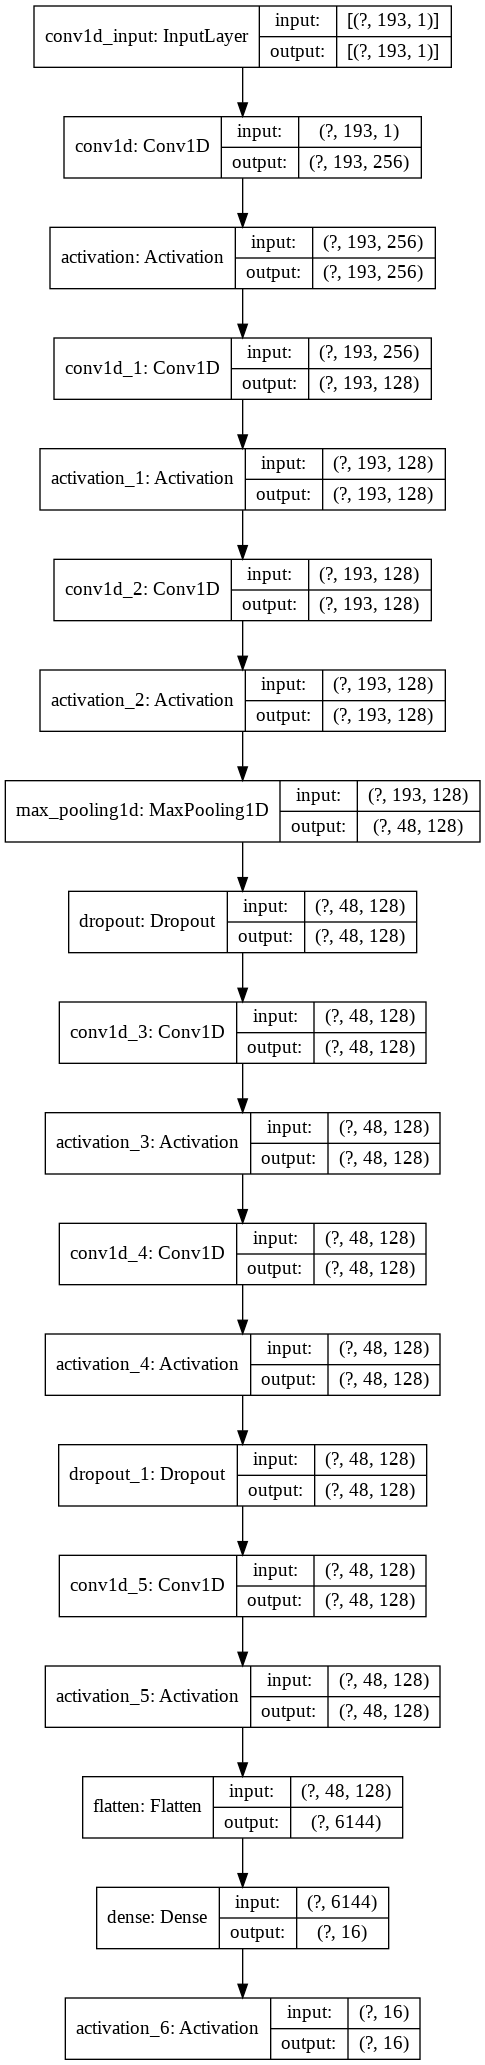

In [68]:
tf.keras.utils.plot_model(
    model,
    to_file="img_model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

dot_img_file = '/content/drive/My Drive/My_AI/img_model_07_RAVDESS-TESS-SAVEE.png'
tf.keras.utils.plot_model(model, to_file = dot_img_file, show_shapes=True)


SAVING THE MODEL

In [72]:
model_name = 'Emotion_Voice_Detection_CNN_model_07_RAVDESS-TESS-SAVEE.h5'
path = '/content/drive/My Drive/My_AI/MY MODELS/'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/Emotion_Voice_Detection_CNN_model_07_RAVDESS-TESS-SAVEE.h5 


In [74]:
import json
model_json = model.to_json()
with open("/content/drive/My Drive/My_AI/MY MODELS/model_07_RAVDESS-TESS-SAVEE.json", "w") as json_file:
    json_file.write(model_json)

LOADING THE MODEL

In [79]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('/content/drive/My Drive/My_AI/MY MODELS/model_07_RAVDESS-TESS-SAVEE.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/saved_models/Emotion_Voice_Detection_CNN_model_07_RAVDESS-TESS-SAVEE.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 87.51%


Predicting emotions on the test data

In [80]:
preds = loaded_model.predict(x_testcnn, batch_size=32, verbose=1)
preds1=preds.argmax(axis=1)

abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})

actual=y_test.argmax(axis=1)

abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

actualdf = pd.DataFrame({'actualvalues': actualvalues})
finaldf = actualdf.join(preddf)

finaldf[10:70]

30/30 [==============================] - 2s 72ms/step


,actualvalues,predictedvalues
10,male_surprised,male_surprised
11,male_angry,male_angry
12,female_disgust,female_disgust
13,female_disgust,female_disgust
14,female_fearful,female_fearful
15,male_sad,male_sad
16,female_disgust,female_disgust
17,female_surprised,female_surprised
18,female_fearful,female_fearful
19,male_sad,male_sad


In [81]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,99
female_calm,24
female_disgust,98
female_fearful,112
female_happy,84
female_neutral,95
female_sad,95
female_surprised,110
male_angry,30


In [82]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,101
female_calm,28
female_disgust,97
female_fearful,119
female_happy,84
female_neutral,98
female_sad,89
female_surprised,105
male_angry,27


In [83]:
finaldf.to_csv('Predictions_RAV-TESS-SAVEE.csv', index=False)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'shuffle', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


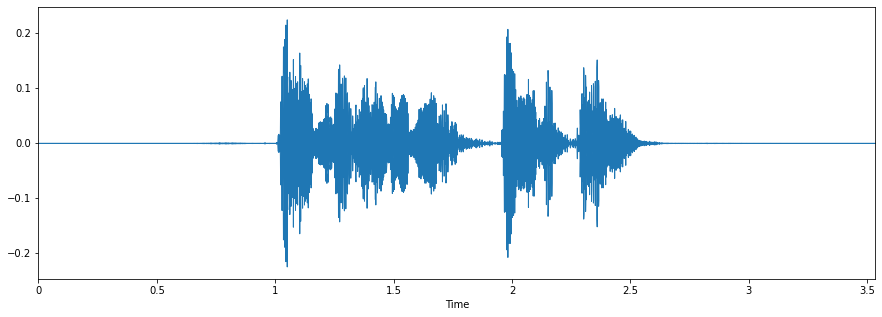

In [84]:
data, sampling_rate = librosa.load('/content/drive/My Drive/My_AI/RawData/03-01-08-02-02-02-21.wav')

% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [85]:
X, sample_rate = librosa.load('/content/drive/My Drive/My_AI/RawData/03-01-08-02-02-02-21.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)

demo_file = os.fspath('/content/drive/My Drive/My_AI/RawData/03-01-08-02-02-02-21.wav')
features_live  = extract_feature(demo_file, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)

In [86]:
features_live = pd.DataFrame(data = features_live)
features_live = features_live.stack().to_frame().T

In [87]:
features_live_2d = np.expand_dims(features_live, axis=2)
live_preds = loaded_model.predict(features_live_2d, batch_size=32, verbose=1)
live_preds = live_preds.argmax(axis=1)
live_preds = live_preds.astype(int).flatten()

live_preds = (lb.inverse_transform((live_preds)))
live_preds

1/1 [==============================] - 0s 1ms/step


array(['male_surprised'], dtype=object)